# Data exploration and preprocessing

## Import matplotlib

In [1]:
# Setup plotting
import matplotlib.pyplot as plt
# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('animation', html='html5')

## Import pandas, Sklearn & tensorflow

In [3]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GroupShuffleSplit

## Data import

In [4]:
df_game_events = pd.read_csv("../data/game_events.csv")
print("Columns in game_events:")
print(df_game_events.columns.tolist())
print("\n")

df_game_metadata = pd.read_csv("../data/game_metadata.csv")
print("Columns in game_metadata:")
print(df_game_metadata.columns.tolist())
print("\n")

df_game_players_stats = pd.read_csv("../data/game_players_stats.csv")
print("Columns in game_players_stats:")
print(df_game_players_stats.columns.tolist())

Columns in game_events:
['id', 'game_id', 'timestamp', 'event_type', 'killer_id', 'killed_id', 'assisting_player_ids', 'drake_type']


Columns in game_metadata:
['game_id', 'date', 'match_id', 'tournament_id', 'tournament_name', 'series_id', 'series_name', 'league_id', 'league_name']


Columns in game_players_stats:
['game_id', 'player_id', 'player_name', 'team_id', 'team_name', 'team_acronym', 'role', 'win', 'game_length', 'champion_name', 'team_kills', 'tower_kills', 'inhibitor_kills', 'dragon_kills', 'herald_kills', 'baron_kills', 'player_kills', 'player_deaths', 'player_assists', 'total_minions_killed', 'gold_earned', 'level', 'total_damage_dealt', 'total_damage_dealt_to_champions', 'total_damage_taken', 'wards_placed', 'largest_killing_spree', 'largest_multi_kill']


### Features in game_events usefull for the player classification

In [33]:
game_events_features = ['timestamp', 'event_type', 'killer_id', 'killed_id']

game_players_stats_features = ['game_length', 'champion_name', 'tower_kills', 'inhibitor_kills', 'dragon_kills', 'herald_kills', 'baron_kills', 
                               'player_kills', 'player_deaths', 'player_assists','total_minions_killed', 'gold_earned', 'level', 
                               'total_damage_dealt','total_damage_dealt_to_champions', 'total_damage_taken', 'wards_placed', 
                               'largest_killing_spree', 'largest_multi_kill']

## Final features used for player classification

In [34]:
game_players_input_features = ['KLA', 'gold_pm', 'lvl_pm', 'creep_score_pm', 'wards_pm',
                            'damage_pm', 'damage_to_champions_pm', 'damage_taken_pm',
                            'greatest_killing_spree', 'greatest_multi_kill']

## Check for missing values

In [35]:
# Check for missing values in game_players_stats_features
print("Missing values count in game_players_stats_features:")
for column in game_players_stats_features:
    missing = df_game_players_stats[column].isna().sum()
    if missing > 0:
        print(f"- {column}: {missing} missing values ({missing/len(df_game_players_stats):.2%})")
        
# Check for missing values in game_events_features
print("Missing values count in game_events_features:")
for column in game_events_features:
    missing = df_game_events[column].isna().sum()
    if missing > 0:
        print(f"- {column}: {missing} missing values ({missing/len(df_game_events):.2%})")

Missing values count in game_players_stats_features:
Missing values count in game_events_features:
- killer_id: 137338 missing values (7.29%)
- killed_id: 842221 missing values (44.69%)


## Explore events with and without Killer ID

<Figure size 1400x800 with 0 Axes>

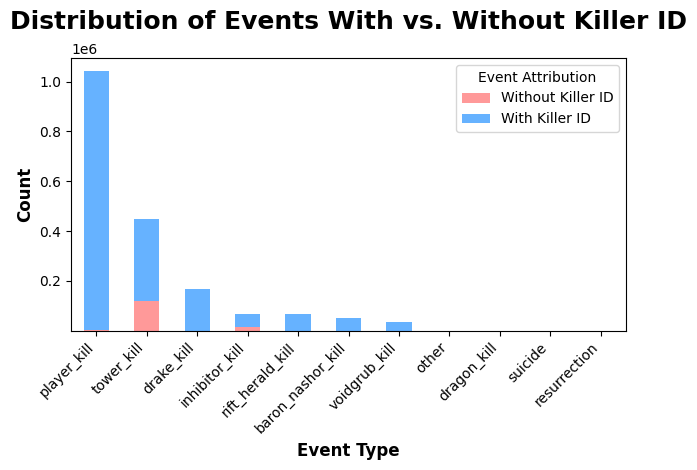

Percentage of each event type occurring without killer_id:
player_kill: 0.20% without killer ID (2129 out of 1042510 events)
tower_kill: 26.52% without killer ID (119158 out of 449292 events)
drake_kill: 0.00% without killer ID (7 out of 169112 events)
inhibitor_kill: 22.20% without killer ID (15301 out of 68934 events)
rift_herald_kill: 1.09% without killer ID (729 out of 66798 events)
baron_nashor_kill: 0.00% without killer ID (1 out of 51947 events)
voidgrub_kill: 0.00% without killer ID (0 out of 35855 events)
other: 0.00% without killer ID (0 out of 252 events)
dragon_kill: 0.00% without killer ID (0 out of 26 events)
suicide: 100.00% without killer ID (13 out of 13 events)
resurrection: 0.00% without killer ID (0 out of 1 events)


In [32]:
# Filter events with and without killer_id
events_without_killer = df_game_events[df_game_events['killer_id'].isna()]
events_with_killer = df_game_events[~df_game_events['killer_id'].isna()]

# Count occurrences of each event type
without_killer_counts = events_without_killer['event_type'].value_counts()
with_killer_counts = events_with_killer['event_type'].value_counts()

# Combine both series into a DataFrame for easier plotting
event_data = pd.DataFrame({
    'Without Killer ID': without_killer_counts,
    'With Killer ID': with_killer_counts
}).fillna(0)

# Sort by total events to make visualization clearer
event_data['Total'] = event_data.sum(axis=1)
event_data = event_data.sort_values('Total', ascending=False)
event_data = event_data.drop('Total', axis=1)

# Create the stacked bar graph
plt.figure(figsize=(14, 8))
event_data.plot(kind='bar', stacked=True, 
                color=['#FF9999', '#66B2FF'])  # Light red for without, blue for with

plt.title("Distribution of Events With vs. Without Killer ID")
plt.xlabel("Event Type")
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Event Attribution")
plt.tight_layout()
plt.show()

# Print percentages for each event type
print("Percentage of each event type occurring without killer_id:")
for event_type in event_data.index:
    with_killer = event_data.loc[event_type, 'With Killer ID']
    without_killer = event_data.loc[event_type, 'Without Killer ID']
    total = with_killer + without_killer
    percentage = (without_killer / total) * 100 if total > 0 else 0
    print(f"{event_type}: {percentage:.2f}% without killer ID ({without_killer:.0f} out of {total:.0f} events)")

## Explore events with and without Killed ID

<Figure size 1400x800 with 0 Axes>

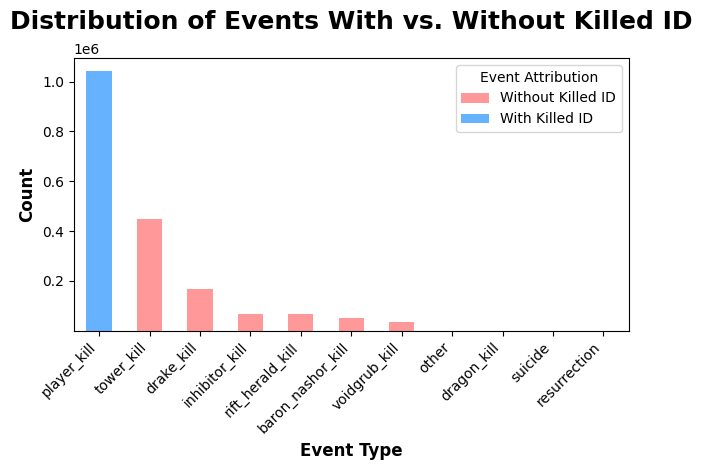

Percentage of each event type occurring without killed_id:
player_kill: 0.00% without killer ID (0 out of 1042510 events)
tower_kill: 100.00% without killer ID (0 out of 449292 events)
drake_kill: 100.00% without killer ID (0 out of 169112 events)
inhibitor_kill: 100.00% without killer ID (0 out of 68934 events)
rift_herald_kill: 100.00% without killer ID (0 out of 66798 events)
baron_nashor_kill: 100.00% without killer ID (0 out of 51947 events)
voidgrub_kill: 100.00% without killer ID (0 out of 35855 events)
other: 100.00% without killer ID (0 out of 252 events)
dragon_kill: 100.00% without killer ID (0 out of 26 events)
suicide: 0.00% without killer ID (0 out of 13 events)
resurrection: 0.00% without killer ID (0 out of 1 events)


In [36]:
# Filter events with and without killer_id
events_without_killed = df_game_events[df_game_events['killed_id'].isna()]
events_with_killed = df_game_events[~df_game_events['killed_id'].isna()]

# Count occurrences of each event type
without_killed_counts = events_without_killed['event_type'].value_counts()
with_killed_counts = events_with_killed['event_type'].value_counts()

# Combine both series into a DataFrame for easier plotting
event_data = pd.DataFrame({
    'Without Killed ID': without_killed_counts,
    'With Killed ID': with_killed_counts
}).fillna(0)

# Sort by total events to make visualization clearer
event_data['Total'] = event_data.sum(axis=1)
event_data = event_data.sort_values('Total', ascending=False)
event_data = event_data.drop('Total', axis=1)

# Create the stacked bar graph
plt.figure(figsize=(14, 8))
event_data.plot(kind='bar', stacked=True, 
                color=['#FF9999', '#66B2FF'])  # Light red for without, blue for with

plt.title("Distribution of Events With vs. Without Killed ID")
plt.xlabel("Event Type")
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Event Attribution")
plt.tight_layout()
plt.show()

# Print percentages for each event type
print("Percentage of each event type occurring without killed_id:")
for event_type in event_data.index:
    with_killed = event_data.loc[event_type, 'With Killed ID']
    without_killed = event_data.loc[event_type, 'Without Killed ID']
    total = with_killed + without_killed
    percentage = (without_killed / total) * 100 if total > 0 else 0
    print(f"{event_type}: {percentage:.2f}% without killer ID ({without_killer:.0f} out of {total:.0f} events)")

## Explore game statistics

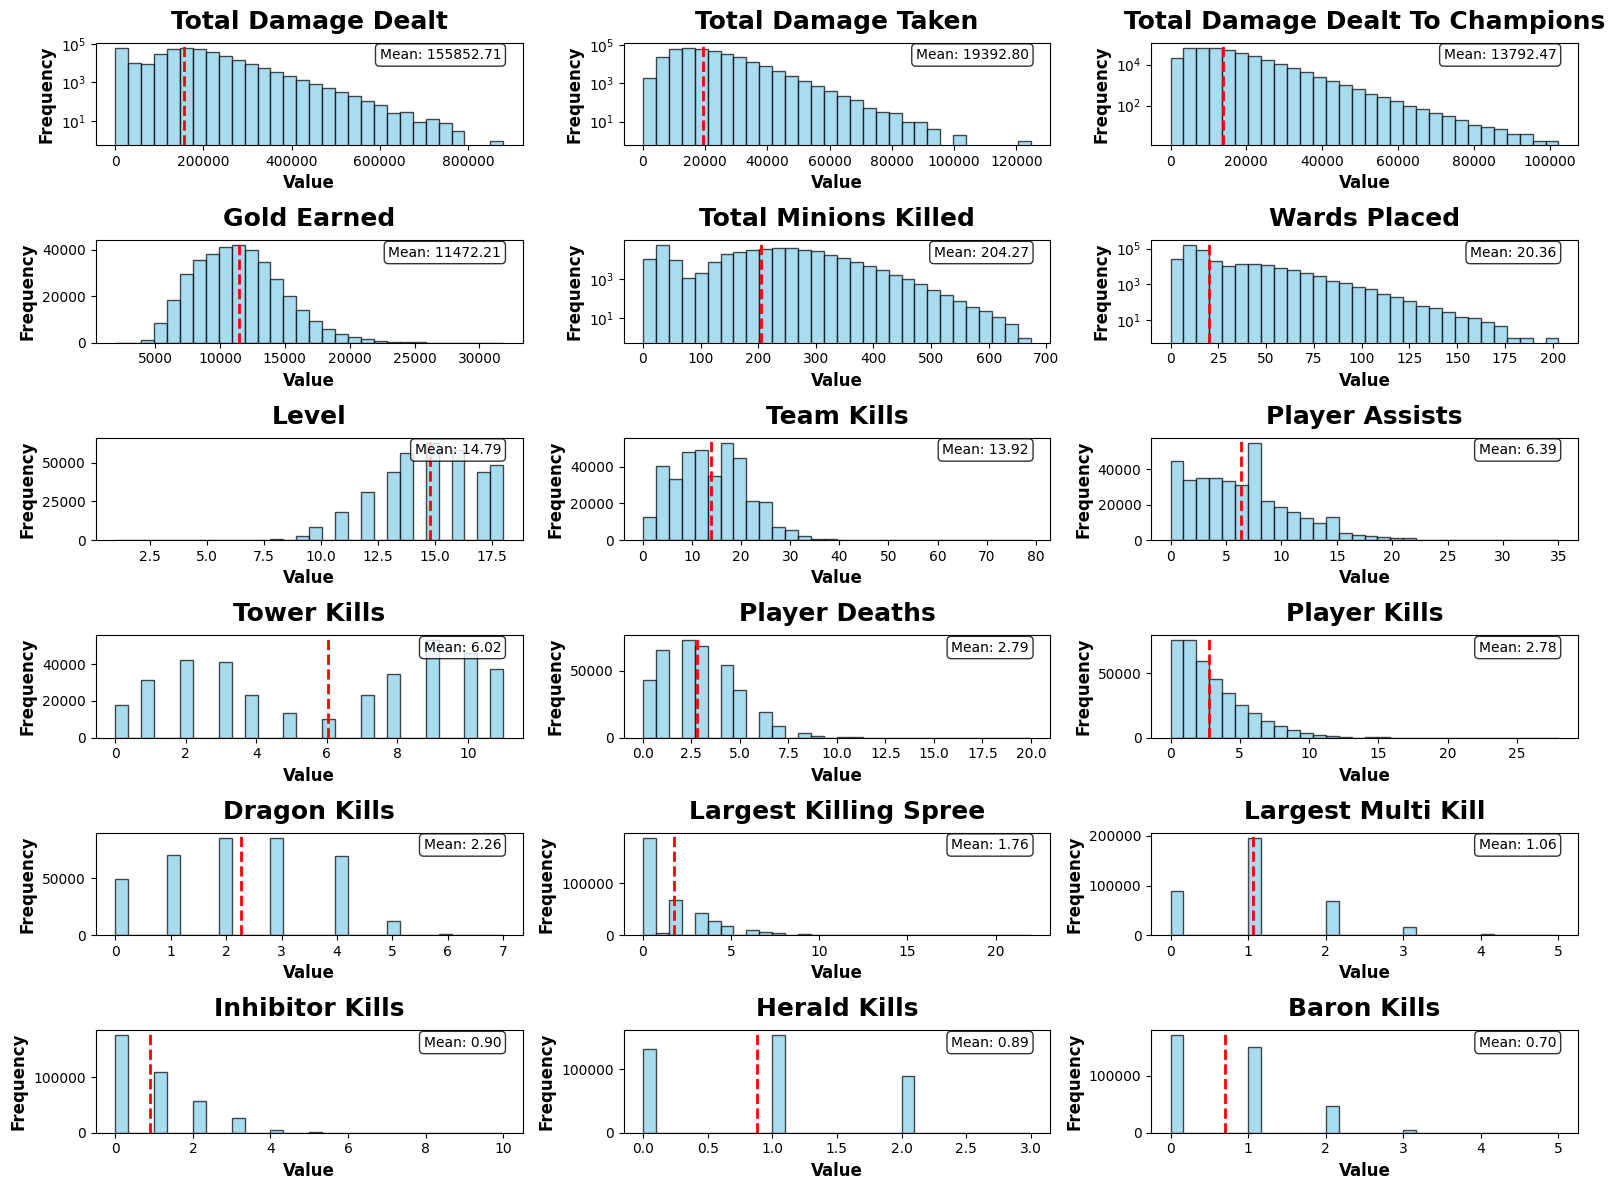

In [42]:
# Explore average values of game player stats with dedicated scales for each feature

# Select numeric columns only for analysis
numeric_columns = df_game_players_stats.select_dtypes(include=['number']).columns.tolist()

numeric_columns = [col for col in numeric_columns if col not in ['game_id', 'game_length', 'champion_name', 'player_id', 'team_id']]

# Calculate means for each numeric column
mean_values = df_game_players_stats[numeric_columns].mean().sort_values(ascending=False)

# Create a figure with multiple subplots, one for each feature
plt.figure(figsize=(16, 12))

# Number of columns in the grid
n_cols = 3
n_rows = (len(mean_values) + n_cols - 1) // n_cols  # Ceiling division

for i, (column, mean_val) in enumerate(mean_values.items(), 1):
    plt.subplot(n_rows, n_cols, i)
    
    # Get data for this column
    data = df_game_players_stats[column].dropna()
    
    # Create histogram with appropriate bins
    plt.hist(data, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    
    # Add a vertical line for the mean
    plt.axvline(mean_val, color='red', linestyle='dashed', linewidth=2)
    
    # Add text annotation for mean value
    plt.text(0.95, 0.95, f'Mean: {mean_val:.2f}', 
             transform=plt.gca().transAxes, 
             ha='right', va='top', 
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Set titles and labels
    plt.title(column.replace('_', ' ').title())
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    
    # Adjust y-scale to log if data has large range
    if data.max() / (data.min() + 1) > 100:  # Add 1 to avoid division by zero
        plt.yscale('log')

# Adjust layout
plt.tight_layout()
plt.show()

# Print a summary table of statistics
summary_stats = pd.DataFrame({
    'Mean': mean_values,
    'Median': df_game_players_stats[numeric_columns].median(),
    'Std Dev': df_game_players_stats[numeric_columns].std(),
    'Min': df_game_players_stats[numeric_columns].min(),
    'Max': df_game_players_stats[numeric_columns].max()
})

#print("Summary Statistics for Game Player Features:")
#print(summary_stats)

## Check number of game played

Dataset Statistics:
Total number of unique games: 37459
Total number of unique players: 4953

Games per player statistics:
Average games per player: 75.62
Median games per player: 31
Min games per player: 1
Max games per player: 710


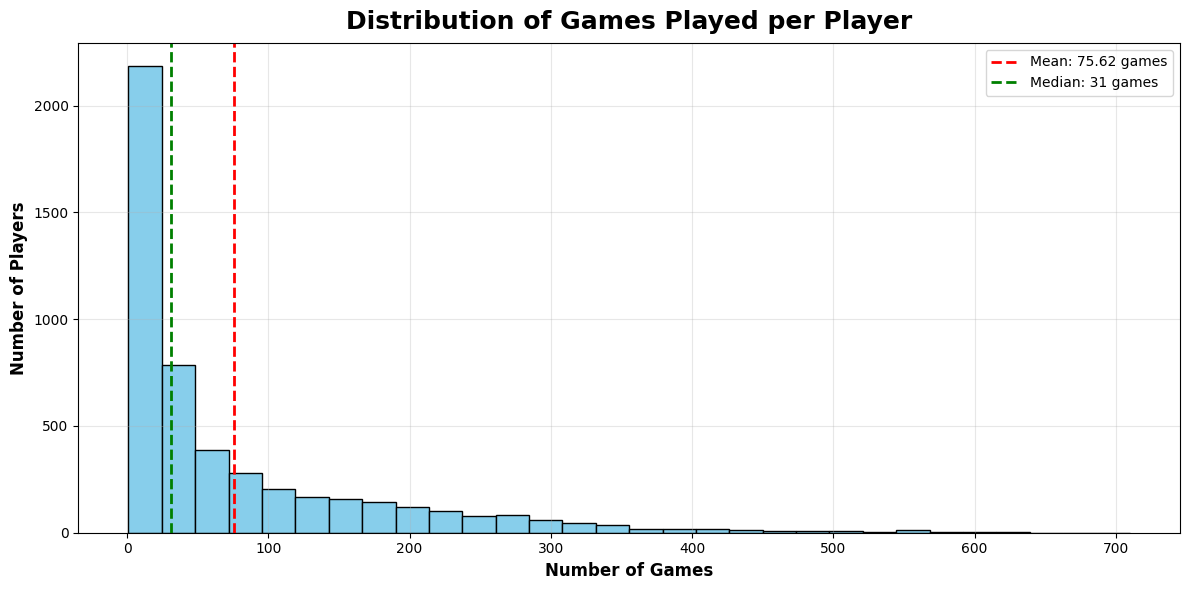


770 players (15.55%) played less than 5 games


In [45]:
# Check game distribution and number of games played
print("Dataset Statistics:")
print(f"Total number of unique games: {df_game_players_stats['game_id'].nunique()}")
print(f"Total number of unique players: {df_game_players_stats['player_id'].nunique()}")

# Calculate games per player
games_per_player = df_game_players_stats.groupby('player_id')['game_id'].nunique()

print(f"\nGames per player statistics:")
print(f"Average games per player: {games_per_player.mean():.2f}")
print(f"Median games per player: {games_per_player.median():.0f}")
print(f"Min games per player: {games_per_player.min()}")
print(f"Max games per player: {games_per_player.max()}")

# Plot the distribution of games per player
plt.figure(figsize=(12, 6))
plt.hist(games_per_player, bins=30, color='skyblue', edgecolor='black')
plt.axvline(games_per_player.mean(), color='red', linestyle='dashed', linewidth=2,
           label=f'Mean: {games_per_player.mean():.2f} games')
plt.axvline(games_per_player.median(), color='green', linestyle='dashed', linewidth=2,
           label=f'Median: {games_per_player.median():.0f} games')

plt.title("Distribution of Games Played per Player")
plt.xlabel("Number of Games")
plt.ylabel("Number of Players")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Calculate what percentage of players played only 1 game
one_game_players = (games_per_player < 5).sum()
percentage = (one_game_players / len(games_per_player)) * 100
print(f"\n{one_game_players} players ({percentage:.2f}%) played less than 5 games")

## Delete data for players who played less than 5 games

In [46]:
# Get player IDs with less than 5 games
games_per_player = df_game_players_stats.groupby('player_id')['game_id'].nunique()
players_less_than_5_games = games_per_player[games_per_player < 5].index.tolist()

# Count records before filtering
count_before = len(df_game_players_stats)

# Filter out players with less than 5 games
df_game_players_stats_filtered = df_game_players_stats[~df_game_players_stats['player_id'].isin(players_less_than_5_games)]

# Count records after filtering
count_after = len(df_game_players_stats_filtered)
records_removed = count_before - count_after

print(f"Filtered {len(players_less_than_5_games)} players who played less than 5 games")
print(f"Removed {records_removed} records ({records_removed/count_before:.2%} of the dataset)")
print(f"Dataset size before: {count_before} records")
print(f"Dataset size after: {count_after} records")

# Replace original DataFrame with filtered version
df_game_players_stats = df_game_players_stats_filtered

# Check if we need to filter events data too (if you want to apply the same filter to game events)
# This is needed only if you want to keep events data consistent with player stats
if 'player_id' in df_game_events.columns:
    events_before = len(df_game_events)
    df_game_events = df_game_events[~df_game_events['player_id'].isin(players_less_than_5_games)]
    events_after = len(df_game_events)
    print(f"Also removed {events_before - events_after} event records")

Filtered 770 players who played less than 5 games
Removed 1907 records (0.51% of the dataset)
Dataset size before: 374554 records
Dataset size after: 372647 records


## Delete rare events

## Delete tower kills without killer_id

## Normalize data

## Hot one encoding

## Create final features

## Export final data